In [1]:
from ase import Atoms
from ase.build import bulk
from ase.constraints import ExpCellFilter, StrainFilter
from ase.optimize import LBFGS, FIRE
import pfp_api_client
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode
print(f"pfp_api_client: {pfp_api_client.__version__}")
import numpy as np
import pandas as pd
import requests
import pprint
import sys
import string
import json
import io
import copy

import ase.io
import ase.calculators.singlepoint



/home/jovyan/.local/lib/python3.7/site-packages/pfp_api_client/__init__.py:36: UserWarning: New version of pfp-api-client is available. Please consider upgrading by `pip install -U pfp-api-client`.
  f"New version of {package_name} is available. Please consider"


pfp_api_client: 1.6.3


In [2]:
from ase.optimize import LBFGS
from ase.build import fcc111, molecule, add_adsorbate
from ase.constraints import ExpCellFilter, StrainFilter


def get_opt_energy(atoms, fmax=0.001, opt_mode: str = "normal"):    
    atoms.set_calculator(calculator)
    if opt_mode == "scale":
        opt1 = LBFGS(StrainFilter(atoms, mask=[1, 1, 1, 0, 0, 0]))
    elif opt_mode == "all":
        opt1 = LBFGS(ExpCellFilter(atoms))
    else:
        opt1 = LBFGS(atoms)
    opt1.run(fmax=fmax)
    return atoms.get_total_energy()

In [3]:
def aseify_reactions(reactions):
    for i, reaction in enumerate(reactions):
        for j, _ in enumerate(reactions[i]['reactionSystems']):
            with io.StringIO() as tmp_file:
                system = reactions[i]['reactionSystems'][j].pop('systems')
                tmp_file.write(system.pop('InputFile'))
                tmp_file.seek(0)
                atoms = ase.io.read(tmp_file, format='json')
            calculator = ase.calculators.singlepoint.SinglePointCalculator(
                atoms,
                energy=system.pop('energy')
            )
            atoms.set_calculator(calculator)
            #print(atoms.get_potential_energy())
            reactions[i]['reactionSystems'][j]['atoms'] = atoms
        # flatten list further into {name: atoms, ...} dictionary
        reactions[i]['reactionSystems'] = {x['name']: x['atoms']
                                          for x in reactions[i]['reactionSystems']}

#ComerUnraveling2022

In [4]:
import os

benchmark="ComerUnraveling2022"
path_json = os.path.join(os.getcwd(),benchmark+".json")
with open(path_json, 'r') as f:
  data = json.load(f)
dat=data['raw_reactions']
dat = copy.deepcopy(dat)
aseify_reactions(dat)

real_E=[round(dat[i]['reactionEnergy'],3) for i in range(0,len(dat))]

print(real_E)
print(len(real_E))

[4.712, 1.882, 4.526, 1.833, 4.095, 1.535, 4.016, 1.48, 1.959, 0.194, 2.186, 0.703, 4.107, 1.506, 4.09, 1.393, 4.852, 2.128, 4.61, 2.028, 0.541, -0.364, 0.926, 0.167, 4.645, 1.716, 4.577, 1.771, 0.391, -0.659, 0.637, -0.363, 4.471, 1.537, 4.429, 1.586, 4.481, 2.097, 4.094, 1.604, -0.276, -0.673, -0.056, -0.624, -0.497, -1.246, 0.092, -0.597, 5.11, 2.004, 4.811, 1.978, -0.247, -1.033, 0.231, -0.749, 4.752, 2.288, 4.709, 2.278, 4.407, 1.603, 4.506, 1.784, 5.025, 2.257, 4.708, 2.081, 3.234, 1.126, 3.403, 1.326, 1.625, 0.168, 1.827, 0.413, 4.817, 2.231, 4.757, 2.573, 3.773, 1.385, 3.691, 1.343, 2.542, 0.462, 2.695, 0.619, 1.462, -0.345, 1.536, -0.241, 4.434, 1.4, 4.526, 1.661, 4.116, 0.881, 3.52, 1.236, 5.448, 2.81, 5.982, 2.739, -1.072, -1.846, -0.386, -1.465, 2.725, 0.504, 2.594, 0.409, -0.753, -1.454, -0.027, -0.822, 4.549, 1.721, 4.503, 1.828, 4.742, 2.082, 4.654, 2.168, 4.777, 2.089, 4.596, 1.908, 5.083, 2.41, 5.474, 2.083]
132


real_E saves reference E

In [5]:
estimator1 = Estimator(calc_mode=EstimatorCalcMode.CRYSTAL, model_version="v3.0.0")#w +U
calculator1 = ASECalculator(estimator1)
estimator2 = Estimator(calc_mode=EstimatorCalcMode.CRYSTAL_U0, model_version="v3.0.0")#no +U
calculator2 = ASECalculator(estimator2)

from ase.optimize import LBFGS
from ase.build import fcc111, molecule, add_adsorbate
from ase.constraints import ExpCellFilter, StrainFilter

def energy_cal(calculator,atoms, fmax=0.001, opt_mode: str = "normal"):    
    atoms.set_calculator(calculator)
    if opt_mode == "scale":
        opt1 = LBFGS(StrainFilter(atoms, mask=[1, 1, 1, 0, 0, 0]))
    elif opt_mode == "all":
        opt1 = LBFGS(ExpCellFilter(atoms))
    else:
        opt1 = LBFGS(atoms)
    opt1.run(fmax=fmax)
    return atoms.get_total_energy()

In [6]:
dat[5]

{'Equation': 'H2O(g) - 0.5H2(g) + * -> HO*',
 'reactants': '{"star": 1, "H2gas": -0.5, "H2Ogas": 1}',
 'products': '{"HOstar": 1}',
 'reactionEnergy': 1.5346961499999736,
 'reactionSystems': {'H2Ogas': Atoms(symbols='H2O', pbc=True, cell=[14.0, 16.526478, 16.596309], calculator=SinglePointCalculator(...)),
  'HOstar': Atoms(symbols='O17Mn8H', pbc=True, cell=[2.937524892, 6.31353593, 27.627071859], calculator=SinglePointCalculator(...)),
  'bulkrutile': Atoms(symbols='Mn2O4', pbc=True, cell=[4.46434406910487, 4.46434406910487, 2.937524892394], calculator=SinglePointCalculator(...)),
  'H2gas': Atoms(symbols='H2', pbc=True, cell=[14.0, 15.0, 16.737166], calculator=SinglePointCalculator(...)),
  'star': Atoms(symbols='O16Mn8', pbc=True, cell=[2.937524892, 6.31353593, 27.627071859], calculator=SinglePointCalculator(...))}}

In [7]:
import json
def stoich(data,i):
    data_string =data[i]['reactants']
    prod_string =data[i]['products']
    reactants_list = list(json.loads(data_string).keys())
    values_list = list(json.loads(data_string).values())
    product = list(json.loads(prod_string).keys())
    return values_list, reactants_list, product

In [8]:
def pfp_calculator(data, fmax_ref, calculator):
    def calculate_energy(rs):
        return energy_cal(calculator, rs, fmax=fmax_ref)
    E_ads_list = []
    
    for i, d in enumerate(data):
        print('<<<<<<<<<<<<<<<<<<<<<<<<<<<<<', i+1, ' out of ', len(data), '>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
        sto, reactants, prod = stoich(data, i)
        energies = [calculate_energy(d['reactionSystems'][r]) for r in reactants]
        E_tot = calculate_energy(d['reactionSystems'][prod[0]])
        E_ads = E_tot - sum([e * s for e, s in zip(energies, sto)])
        E_ads_list.append(round(E_ads, 3))
        
        proceed = round((i+1) / len(data) * 100, 2)
        print(status(proceed), proceed, '% done')
    
    return E_ads_list
def status(proceed):    
    num = int(proceed/5)  
    return '🟩'*num+'⬜️'*(20-num)


In [9]:
#pfp_E_0p1=pfp_calculator(dat,0.1,calculator2)
pfp_E_0p03_U=pfp_calculator(dat,0.03,calculator2)

<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 1  out of  132 >>>>>>>>>>>>>>>>>>>>>>>>>>>>
       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 09:08:10     -114.316791*       1.9775
LBFGS:    1 09:08:10     -114.463366*       1.7811
LBFGS:    2 09:08:11     -114.731347*       1.4300
LBFGS:    3 09:08:11     -114.768937*       0.8825
LBFGS:    4 09:08:11     -114.815242*       0.3426
LBFGS:    5 09:08:11     -114.824068*       0.3337
LBFGS:    6 09:08:11     -114.861528*       0.3693
LBFGS:    7 09:08:11     -114.878692*       0.3215
LBFGS:    8 09:08:11     -114.902694*       0.3708
LBFGS:    9 09:08:11     -114.921848*       0.4155
LBFGS:   10 09:08:11     -114.959291*       0.6026
LBFGS:   11 09:08:11     -114.989463*       0.6520
LBFGS:   12 09:08:11     -115.016209*       0.4625
LBFGS:   13 09:08:11     -115.037072*       0.3307
LBFGS:   14 09:08:11     -115.047534*       0.2458
LBFGS:   15 09:08:11     -115.061921*       0.1775
LBFGS:   16

Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 09:10:22     -134.429383*       2.6039


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    1 09:10:22     -134.609134*       1.3503


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    2 09:10:22     -134.705383*       0.5651


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    3 09:10:22     -134.730027*       0.5447


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    4 09:10:22     -134.767578*       0.4541


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    5 09:10:22     -134.775731*       0.2981


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    6 09:10:22     -134.789104*       0.2606


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    7 09:10:22     -134.794686*       0.2703


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    8 09:10:22     -134.800616*       0.2451


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    9 09:10:22     -134.803573*       0.1058


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   10 09:10:22     -134.805408*       0.1060


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   11 09:10:22     -134.806953*       0.1272


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   12 09:10:22     -134.809077*       0.1677


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   13 09:10:22     -134.810817*       0.1092


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   14 09:10:22     -134.811645*       0.0488


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   15 09:10:22     -134.811992*       0.0381


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   16 09:10:23     -134.812314*       0.0695


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   17 09:10:23     -134.812702*       0.0715


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   18 09:10:23     -134.813051*       0.0395


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   19 09:10:23     -134.813316*       0.0296
       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 09:10:23       -4.532429*       0.0663
LBFGS:    1 09:10:23       -4.532485*       0.0073
       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 09:10:23      -10.076631*       0.0270


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 09:10:23     -139.410338*       2.6473


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    1 09:10:23     -139.593957*       1.3333


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    2 09:10:23     -139.688255*       0.6344


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    3 09:10:23     -139.712215*       0.5573


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    4 09:10:23     -139.747274*       0.3854


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    5 09:10:23     -139.754987*       0.2366


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    6 09:10:23     -139.766348*       0.2481


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    7 09:10:23     -139.770936*       0.2376


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    8 09:10:23     -139.775721*       0.2065


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    9 09:10:23     -139.778769*       0.1299


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   10 09:10:23     -139.781221*       0.1413


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   11 09:10:24     -139.783602*       0.1642


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   12 09:10:24     -139.786400*       0.1935


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   13 09:10:24     -139.789135*       0.1155


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   14 09:10:24     -139.790463*       0.0585


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   15 09:10:24     -139.791133*       0.0658


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   16 09:10:24     -139.791644*       0.0925


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   17 09:10:24     -139.792136*       0.0818


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   18 09:10:24     -139.792650*       0.0492


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   19 09:10:24     -139.793134*       0.0430


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   20 09:10:24     -139.793509*       0.0490


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   21 09:10:24     -139.793749*       0.0349


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   22 09:10:24     -139.793864*       0.0217
🟩🟩🟩⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️ 15.91 % done
<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 22  out of  132 >>>>>>>>>>>>>>>>>>>>>>>>>>>>


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 09:10:24     -134.429386*       2.6039


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    1 09:10:24     -134.609128*       1.3503


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    2 09:10:24     -134.705386*       0.5651


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    3 09:10:24     -134.730027*       0.5447


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    4 09:10:24     -134.767573*       0.4541


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    5 09:10:24     -134.775740*       0.2981


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    6 09:10:25     -134.789102*       0.2606


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    7 09:10:25     -134.794690*       0.2703


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    8 09:10:25     -134.800615*       0.2451


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    9 09:10:25     -134.803575*       0.1058


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   10 09:10:25     -134.805406*       0.1060


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   11 09:10:25     -134.806952*       0.1272


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   12 09:10:25     -134.809076*       0.1677


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   13 09:10:25     -134.810817*       0.1092


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   14 09:10:25     -134.811634*       0.0488


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   15 09:10:25     -134.811989*       0.0381


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   16 09:10:25     -134.812315*       0.0695


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   17 09:10:25     -134.812696*       0.0715


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   18 09:10:25     -134.813044*       0.0395


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   19 09:10:25     -134.813309*       0.0296
       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 09:10:25       -4.532429*       0.0663
LBFGS:    1 09:10:25       -4.532485*       0.0073
       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 09:10:25      -10.076631*       0.0270


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 09:10:26     -142.720325*       2.6323


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    1 09:10:26     -142.897888*       1.3429


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    2 09:10:26     -142.984656*       0.5539


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    3 09:10:26     -143.005539*       0.4679


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    4 09:10:26     -143.037680*       0.4243


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    5 09:10:26     -143.044491*       0.2419


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    6 09:10:26     -143.054177*       0.2196


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    7 09:10:26     -143.057411*       0.1942


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    8 09:10:26     -143.060861*       0.1663


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    9 09:10:26     -143.062467*       0.1058


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   10 09:10:26     -143.063520*       0.0778


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   11 09:10:26     -143.064466*       0.1037


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   12 09:10:26     -143.065873*       0.1316


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   13 09:10:26     -143.066934*       0.0831


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   14 09:10:26     -143.067485*       0.0395


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   15 09:10:26     -143.067768*       0.0411


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   16 09:10:26     -143.068056*       0.0665


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   17 09:10:27     -143.068323*       0.0625


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   18 09:10:27     -143.068567*       0.0309


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   19 09:10:27     -143.068702*       0.0249
🟩🟩🟩⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️ 16.67 % done
<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 23  out of  132 >>>>>>>>>>>>>>>>>>>>>>>>>>>>


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 09:10:27     -100.479432*       3.1583


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    1 09:10:27     -100.663093*       1.8181


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    2 09:10:27     -100.788380*       0.8950


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    3 09:10:27     -100.822793*       0.6855


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    4 09:10:27     -100.895547*       0.4857


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    5 09:10:27     -100.914547*       0.5243


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    6 09:10:27     -100.935163*       0.4258


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    7 09:10:27     -100.948878*       0.4593


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    8 09:10:27     -100.965679*       0.4975


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    9 09:10:27     -100.980543*       0.3597


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   10 09:10:27     -100.998064*       0.5514


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   11 09:10:27     -101.015804*       0.5611


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   12 09:10:27     -101.031561*       0.3902


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   13 09:10:27     -101.043400*       0.3265


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   14 09:10:28     -101.051777*       0.1869


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   15 09:10:28     -101.055874*       0.1334


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   16 09:10:28     -101.058576*       0.1252


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   17 09:10:28     -101.060833*       0.1386


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   18 09:10:28     -101.062829*       0.0914


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   19 09:10:28     -101.064600*       0.1006


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   20 09:10:28     -101.066019*       0.0939


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   21 09:10:28     -101.067322*       0.0890


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   22 09:10:28     -101.068772*       0.1049


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   23 09:10:28     -101.070343*       0.1070


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   24 09:10:28     -101.071520*       0.1058


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   25 09:10:28     -101.072628*       0.0776


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   26 09:10:28     -101.073257*       0.0699


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   27 09:10:28     -101.073776*       0.0583


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   28 09:10:28     -101.074008*       0.0315


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   29 09:10:28     -101.074180*       0.0325


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   30 09:10:28     -101.074325*       0.0315


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   31 09:10:29     -101.074504*       0.0279
       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 09:10:29       -4.532429*       0.0663
LBFGS:    1 09:10:29       -4.532485*       0.0073
       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 09:10:29      -10.076631*       0.0270


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 09:10:29     -105.308616*       3.1631


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    1 09:10:29     -105.500596*       1.8179


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    2 09:10:29     -105.626951*       0.8804


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    3 09:10:29     -105.661662*       0.6721


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    4 09:10:29     -105.732767*       0.4663


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    5 09:10:29     -105.752647*       0.5097


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    6 09:10:29     -105.775497*       0.4241


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    7 09:10:29     -105.790549*       0.4729


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    8 09:10:29     -105.807884*       0.5104


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    9 09:10:29     -105.822620*       0.3690


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   10 09:10:29     -105.841612*       0.5482


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   11 09:10:29     -105.862165*       0.5965


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   12 09:10:29     -105.882155*       0.4415


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   13 09:10:29     -105.896818*       0.3693


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   14 09:10:30     -105.906802*       0.1805


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   15 09:10:30     -105.911951*       0.1498


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   16 09:10:30     -105.915484*       0.1398


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   17 09:10:30     -105.918274*       0.1665


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   18 09:10:30     -105.920645*       0.1182


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   19 09:10:30     -105.922752*       0.1043


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   20 09:10:30     -105.924360*       0.1012


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   21 09:10:30     -105.925885*       0.1119


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   22 09:10:30     -105.927523*       0.0956


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   23 09:10:30     -105.929055*       0.1056


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   24 09:10:30     -105.930329*       0.0943


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   25 09:10:30     -105.931363*       0.0829


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   26 09:10:30     -105.932151*       0.0756


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   27 09:10:30     -105.932812*       0.0487


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   28 09:10:30     -105.933162*       0.0348


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   29 09:10:30     -105.933349*       0.0329


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   30 09:10:30     -105.933516*       0.0336


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   31 09:10:31     -105.933704*       0.0326


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   32 09:10:31     -105.933829*       0.0319


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   33 09:10:31     -105.933913*       0.0255
🟩🟩🟩⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️ 17.42 % done
<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 24  out of  132 >>>>>>>>>>>>>>>>>>>>>>>>>>>>


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 09:10:31     -100.479436*       3.1583


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    1 09:10:31     -100.663098*       1.8182


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    2 09:10:31     -100.788382*       0.8950


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    3 09:10:31     -100.822792*       0.6855


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    4 09:10:31     -100.895552*       0.4857


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    5 09:10:31     -100.914547*       0.5243


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    6 09:10:31     -100.935167*       0.4258


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    7 09:10:31     -100.948887*       0.4593


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    8 09:10:31     -100.965688*       0.4975


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    9 09:10:31     -100.980540*       0.3597


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   10 09:10:31     -100.998060*       0.5514


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   11 09:10:31     -101.015810*       0.5611


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   12 09:10:31     -101.031567*       0.3902


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   13 09:10:31     -101.043395*       0.3265


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   14 09:10:31     -101.051770*       0.1869


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   15 09:10:32     -101.055874*       0.1334


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   16 09:10:32     -101.058578*       0.1252


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   17 09:10:32     -101.060840*       0.1386


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   18 09:10:32     -101.062835*       0.0914


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   19 09:10:32     -101.064610*       0.1006


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   20 09:10:32     -101.066015*       0.0939


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   21 09:10:32     -101.067319*       0.0890


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   22 09:10:32     -101.068771*       0.1050


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   23 09:10:32     -101.070340*       0.1070


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   24 09:10:32     -101.071514*       0.1058


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   25 09:10:32     -101.072622*       0.0777


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   26 09:10:32     -101.073266*       0.0699


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   27 09:10:32     -101.073772*       0.0583


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   28 09:10:32     -101.074012*       0.0315


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   29 09:10:32     -101.074180*       0.0325


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   30 09:10:32     -101.074328*       0.0315


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   31 09:10:32     -101.074503*       0.0279
       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 09:10:33       -4.532429*       0.0663
LBFGS:    1 09:10:33       -4.532485*       0.0073
       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 09:10:33      -10.076631*       0.0270


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 09:10:33     -108.398357*       3.1617


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    1 09:10:33     -108.587861*       1.8170


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    2 09:10:33     -108.718767*       0.9133


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    3 09:10:33     -108.752743*       0.6787


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    4 09:10:33     -108.818727*       0.4526


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    5 09:10:33     -108.835870*       0.4530


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    6 09:10:33     -108.858558*       0.3965


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    7 09:10:33     -108.872508*       0.4502


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    8 09:10:33     -108.887408*       0.4502


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:    9 09:10:33     -108.899133*       0.3008


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   10 09:10:33     -108.913994*       0.4434


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   11 09:10:33     -108.930325*       0.4800


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   12 09:10:33     -108.947333*       0.4107


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   13 09:10:33     -108.959766*       0.3187


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   14 09:10:34     -108.967305*       0.1647


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   15 09:10:34     -108.971300*       0.1401


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   16 09:10:34     -108.974381*       0.1428


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   17 09:10:34     -108.977109*       0.1648


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   18 09:10:34     -108.979398*       0.1116


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   19 09:10:34     -108.981253*       0.1152


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   20 09:10:34     -108.982882*       0.1153


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   21 09:10:34     -108.984599*       0.1141


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   22 09:10:34     -108.986515*       0.1250


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   23 09:10:34     -108.988325*       0.0793


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   24 09:10:34     -108.989706*       0.0931


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   25 09:10:34     -108.990832*       0.0889


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   26 09:10:34     -108.991892*       0.0948


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   27 09:10:34     -108.992796*       0.0810


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   28 09:10:34     -108.993287*       0.0371


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   29 09:10:34     -108.993535*       0.0392


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   30 09:10:34     -108.993785*       0.0428


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   31 09:10:35     -108.994130*       0.0463


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   32 09:10:35     -108.994466*       0.0363


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   33 09:10:35     -108.994711*       0.0336


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   34 09:10:35     -108.994869*       0.0308


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   35 09:10:35     -108.995036*       0.0332


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   36 09:10:35     -108.995305*       0.0428


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   37 09:10:35     -108.995618*       0.0418


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   38 09:10:35     -108.995954*       0.0452


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   39 09:10:35     -108.996273*       0.0483


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   40 09:10:35     -108.996593*       0.0489


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   41 09:10:35     -108.996870*       0.0545


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   42 09:10:35     -108.997124*       0.0458


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   43 09:10:35     -108.997388*       0.0353


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   44 09:10:35     -108.997692*       0.0431


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   45 09:10:35     -108.998053*       0.0447


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   46 09:10:35     -108.998437*       0.0606


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   47 09:10:35     -108.998856*       0.0586


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   48 09:10:36     -108.999294*       0.0519


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   49 09:10:36     -108.999895*       0.0636


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   50 09:10:36     -109.000590*       0.0623


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   51 09:10:36     -109.001184*       0.0637


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   52 09:10:36     -109.001607*       0.0515


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   53 09:10:36     -109.001923*       0.0495


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   54 09:10:36     -109.002170*       0.0450


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   55 09:10:36     -109.002405*       0.0396


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   56 09:10:36     -109.002539*       0.0381


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   57 09:10:36     -109.002728*       0.0330


Runtime warning (ID 1001): Experimental element was detected.         You can suppress this message with Estimator.set_message_status().


LBFGS:   58 09:10:36     -109.002856*       0.0212
🟩🟩🟩⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️ 18.18 % done
<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 25  out of  132 >>>>>>>>>>>>>>>>>>>>>>>>>>>>
       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 09:10:36     -177.182077*       3.4564
LBFGS:    1 09:10:36     -177.673544*       2.3472
LBFGS:    2 09:10:36     -178.071310*       1.7251
LBFGS:    3 09:10:36     -178.146063*       0.6649
LBFGS:    4 09:10:36     -178.196745*       0.5308
LBFGS:    5 09:10:36     -178.253246*       0.5930
LBFGS:    6 09:10:37     -178.272303*       0.6033
LBFGS:    7 09:10:37     -178.315935*       0.4178
LBFGS:    8 09:10:37     -178.334213*       0.3342
LBFGS:    9 09:10:37     -178.344385*       0.1865
LBFGS:   10 09:10:37     -178.351108*       0.1929
LBFGS:   11 09:10:37     -178.360273*       0.2771
LBFGS:   12 09:10:37     -178.369609*       0.3223
LBFGS:   13 09:10:37     -178.378189*       0.2562
LBFGS:   1

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [10]:
#pfp_E_0p1_U=pfp_calculator(dat,0.1,calculator1)

In [11]:
'''pfp_E_0p1=[2.919, 1.013, 3.085, 1.122, 2.776, 0.845, 2.911, 1.041, 0.954, 0.224, 1.063, 0.172, 4.26, 1.517, 4.331, 1.562, 4.788, 2.219, -0.503, 2.201, 0.565, -0.441, 0.68, -0.115, 4.766, 1.494, 4.708, 1.511, 0.384, -0.806, 0.616, -0.584, 4.605, 1.387, 4.563, 1.499, 4.175, 1.705, 2.49, 1.518, -0.643, -0.838, -0.385, -0.678, -0.568, -1.358, -0.378, -1.047, 4.993, 2.066, 4.959, 2.056, -0.214, -0.918, 0.219, -0.713, 4.778, 2.165, 4.618, 2.019, 4.628, 1.859, 4.65, 1.986, 5.144, 2.484, -4.055, -5.459, 1.855, 0.732, 2.015, 0.764, 1.642, -0.009, 1.872, 0.242, 4.968, 2.468, -3.016, -1.77, 3.499, 1.296, 3.627, 1.369, 2.496, 0.447, 2.67, 0.622, 1.39, -0.323, 1.508, -0.205, 4.556, 1.584, 4.615, 1.785, 3.594, 0.743, 3.813, 1.357, 5.513, 2.967, 1.55, -0.125, -0.943, -1.728, -0.315, -1.375, 2.703, 0.423, 2.653, 0.381, -6.642, -12.303, -0.676, -1.289, 4.659, 1.544, 4.73, 1.682, 4.733, 2.248, -2.09, -2.476, 4.869, 2.154, 0.317, 2.202, 5.02, 2.294, 0.272, -3.024]
print(pfp_E_0p1)'''

'pfp_E_0p1=[2.919, 1.013, 3.085, 1.122, 2.776, 0.845, 2.911, 1.041, 0.954, 0.224, 1.063, 0.172, 4.26, 1.517, 4.331, 1.562, 4.788, 2.219, -0.503, 2.201, 0.565, -0.441, 0.68, -0.115, 4.766, 1.494, 4.708, 1.511, 0.384, -0.806, 0.616, -0.584, 4.605, 1.387, 4.563, 1.499, 4.175, 1.705, 2.49, 1.518, -0.643, -0.838, -0.385, -0.678, -0.568, -1.358, -0.378, -1.047, 4.993, 2.066, 4.959, 2.056, -0.214, -0.918, 0.219, -0.713, 4.778, 2.165, 4.618, 2.019, 4.628, 1.859, 4.65, 1.986, 5.144, 2.484, -4.055, -5.459, 1.855, 0.732, 2.015, 0.764, 1.642, -0.009, 1.872, 0.242, 4.968, 2.468, -3.016, -1.77, 3.499, 1.296, 3.627, 1.369, 2.496, 0.447, 2.67, 0.622, 1.39, -0.323, 1.508, -0.205, 4.556, 1.584, 4.615, 1.785, 3.594, 0.743, 3.813, 1.357, 5.513, 2.967, 1.55, -0.125, -0.943, -1.728, -0.315, -1.375, 2.703, 0.423, 2.653, 0.381, -6.642, -12.303, -0.676, -1.289, 4.659, 1.544, 4.73, 1.682, 4.733, 2.248, -2.09, -2.476, 4.869, 2.154, 0.317, 2.202, 5.02, 2.294, 0.272, -3.024]\nprint(pfp_E_0p1)'

In [12]:
'''pfp_E_0p1_U=[4.787, 2.05, 4.594, 1.969, 4.006, 1.473, 4.057, 1.544, 1.969, 0.636, 2.023, 0.54, 4.26, 1.517, 4.331, 1.562, 4.788, 2.219, -0.503, 2.201, 0.565, -0.441, 0.68, -0.115, 4.766, 1.494, 4.708, 1.511, 0.384, -0.806, 0.616, -0.584, 4.605, 1.387, 4.563, 1.499, 4.603, 2.1, 1.998, 0.798, 0.508, -0.325, 0.781, -0.147, -0.568, -1.358, -0.378, -1.047, 4.993, 2.066, 4.959, 2.056, -0.214, -0.918, 0.219, -0.713, 4.891, 2.317, 4.743, 2.178, 4.628, 1.859, 4.65, 1.986, 5.144, 2.484, -4.833, -6.361, 3.161, 1.251, 3.341, 1.433, 1.642, -0.009, 1.872, 0.242, 4.968, 2.468, -1.946, -5.825, 3.859, 1.607, 3.985, 1.68, 2.496, 0.447, 2.67, 0.622, 1.39, -0.323, 1.508, -0.205, 4.556, 1.584, 4.615, 1.785, 3.594, 0.743, 3.813, 1.357, 5.513, 2.967, 5.317, 1.893, -0.943, -1.728, -0.315, -1.375, 2.703, 0.423, 2.653, 0.381, -10.216, -11.175, -0.034, -0.97, 4.659, 1.544, 4.73, 1.682, 4.733, 2.248, 0.005, -1.447, 4.869, 2.154, 0.335, 2.202, 5.02, 2.294, -2.675, -3.033]
print(pfp_E_0p1_U)'''

'pfp_E_0p1_U=[4.787, 2.05, 4.594, 1.969, 4.006, 1.473, 4.057, 1.544, 1.969, 0.636, 2.023, 0.54, 4.26, 1.517, 4.331, 1.562, 4.788, 2.219, -0.503, 2.201, 0.565, -0.441, 0.68, -0.115, 4.766, 1.494, 4.708, 1.511, 0.384, -0.806, 0.616, -0.584, 4.605, 1.387, 4.563, 1.499, 4.603, 2.1, 1.998, 0.798, 0.508, -0.325, 0.781, -0.147, -0.568, -1.358, -0.378, -1.047, 4.993, 2.066, 4.959, 2.056, -0.214, -0.918, 0.219, -0.713, 4.891, 2.317, 4.743, 2.178, 4.628, 1.859, 4.65, 1.986, 5.144, 2.484, -4.833, -6.361, 3.161, 1.251, 3.341, 1.433, 1.642, -0.009, 1.872, 0.242, 4.968, 2.468, -1.946, -5.825, 3.859, 1.607, 3.985, 1.68, 2.496, 0.447, 2.67, 0.622, 1.39, -0.323, 1.508, -0.205, 4.556, 1.584, 4.615, 1.785, 3.594, 0.743, 3.813, 1.357, 5.513, 2.967, 5.317, 1.893, -0.943, -1.728, -0.315, -1.375, 2.703, 0.423, 2.653, 0.381, -10.216, -11.175, -0.034, -0.97, 4.659, 1.544, 4.73, 1.682, 4.733, 2.248, 0.005, -1.447, 4.869, 2.154, 0.335, 2.202, 5.02, 2.294, -2.675, -3.033]\nprint(pfp_E_0p1_U)'

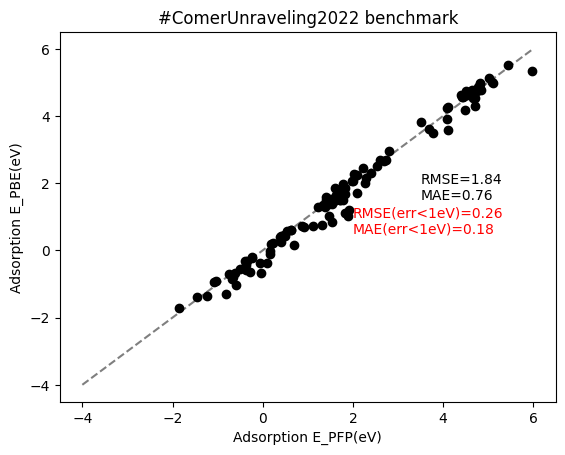

NameError: name 'pfp_E_0p1_U' is not defined

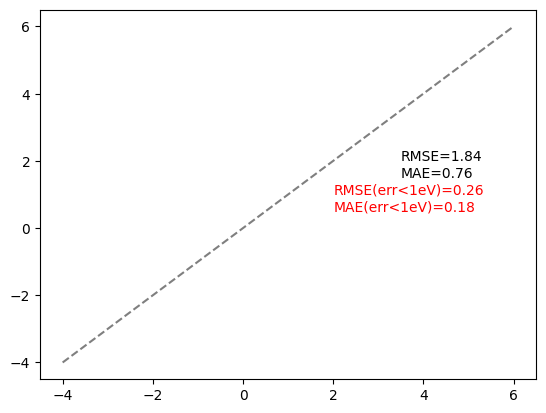

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

def err_est(pfp_E):
    rms = mean_squared_error(real_E, pfp_E, squared=False)
    mae=mean_absolute_error(real_E, pfp_E)
    rms_str='RMSE='+str(round(rms,2))
    mae_str='MAE='+str(round(mae,2))
    err=[]
    err=[rms_str,mae_str]
    return err
def err_est_wo_outlier(pfp_E):
    temp=[]
    real_temp=[]
    real_out =[]
    pfp_out =[]
    out=[]
    for i in range(0,len(pfp_E)):
     if abs(real_E[i]-pfp_E[i])<1:
        temp.append(pfp_E[i])
        real_temp.append(real_E[i])
     else:
        pfp_out.append(pfp_E[i])
        real_out.append(real_E[i])
        out.append(i)
    rms = mean_squared_error(real_temp, temp, squared=False)
    mae=mean_absolute_error(real_temp, temp)
    rms_str='RMSE(err<1eV)='+str(round(rms,2))
    mae_str='MAE(err<1eV)='+str(round(mae,2))
    err=[]
    err=[rms_str,mae_str]
    return err, real_out, pfp_out, out ,real_temp,temp

err3, real_out, pfp_out, out, real_wo_outlier,pfp_wo_outlier =err_est_wo_outlier(pfp_E_0p03_U)
#err1=err_est(pfp_E_0p1)
err2=err_est(pfp_E_0p03_U)
def plotall():
    plt.plot([-4,-1,0,1, 2, 3,6],[-4,-1,0,1, 2, 3,6],'--',color='black',alpha=0.5)
    plt.text(3.5,2,err2[0])
    plt.text(3.5,1.5,err2[1])
    plt.text(2,1,err3[0],color='red')
    plt.text(2,0.5,err3[1],color='red')
    #plt.scatter(real_out,pfp_out,color='black')
    plt.scatter(real_E,pfp_E_0p1_U,color='black')
    plt.scatter(real_out,pfp_out,color='red',marker='x', s = 100 )
    plt.title('#'+benchmark+' benchmark')
    plt.xlabel('Adsorption E_PFP(eV)')
    plt.ylabel('Adsorption E_PBE(eV)')
    plt.show()
def plot_wo_out():
    plt.plot([-4,-1,0,1, 2, 3,6],[-4,-1,0,1, 2, 3,6],'--',color='black',alpha=0.5)
    plt.text(3.5,2,err2[0])
    plt.text(3.5,1.5,err2[1])
    plt.text(2,1,err3[0],color='red')
    plt.text(2,0.5,err3[1],color='red')
    #plt.scatter(real_out,pfp_out,color='black')
    plt.scatter(real_wo_outlier,pfp_wo_outlier,color='black')
    plt.title('#'+benchmark+' benchmark')
    plt.xlabel('Adsorption E_PFP(eV)')
    plt.ylabel('Adsorption E_PBE(eV)')
    plt.show()
plot_wo_out()
plotall()

In [ ]:
from ase.io import write
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pfcc_extras.visualize.ase import view_ase_atoms
from ase.io.vasp import read_vasp
from ase.io import Trajectory

subscript = str.maketrans("0123456789-_", "₀₁₂₃₄₅₆₇₈₉→→")
print('How many outliers?'+str(len(out)))
for i in range(0,len(out)):
    slab=dat[out[i]]['reactionSystems']['star']
    name=str(dat[out[i]]['reactionSystems']['star'].symbols).translate(subscript)
    titles =str(name)+'_Err(eV)='+str(round(abs(real_out[i]-pfp_out[i]),2))+'eV'
    view_ase_atoms(slab, rotation="0x,0y,0z", figsize=(3, 3), title=titles, scale=40)
    view_ase_atoms(slab, rotation="0x,90y,90z", figsize=(2, 2), scale=40)

In [ ]:
def err_est_wo_outlier(pfp_E):
    temp=[]
    real_temp=[]
    for i in range(0,len(pfp_E)):
     if abs(real_E[i]-pfp_E[i])<1:
        temp.append(pfp_E[i])
        real_temp.append(real_E[i])
    rms = mean_squared_error(real_temp, temp, squared=False)
    mae=mean_absolute_error(real_temp, temp)
    rms_str='RMSE='+str(round(rms,2))
    mae_str='MAE='+str(round(mae,2))
    err=[]
    err=[rms_str,mae_str]
    return err
err1=err_est_wo_outlier(pfp_E_0p1)
print(err1[0])
print(err1[1])